# Get Affine Tranfrom
Need to get affine transformation form Realsense RGB Image to Ximea Image so we know where our eye positions are in ximea space. We'll do this per-task for now.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

#paths for all the things
ximea_path = '/hmet_data/pngs/sandwich/ag/1/'
rsrgb_path = '/hmet_data/raw/2020_02_26/011/'
index_file = '/hmet_data/analysis/sandwich/ag/1/common_timeline.csv'
ximea_idx_file = '/hmet_data/analysis/sandwich/ag/1/common_timeline_ximea_sampleidx.csv'
rsrgb_idx_file = '/hmet_data/analysis/sandwich/ag/1/common_timeline_rsrgb_sampleidx.csv'

#load index lists
ximea_idx =  np.loadtxt(ximea_idx_file, delimiter=',', skiprows=0)
rsrgb_idx =  np.loadtxt(rsrgb_idx_file, delimiter=',', skiprows=0)

#get index
tidx = len(ximea_idx)//2
ximea_frame = int(ximea_idx[tidx])
rsrgb_frame = int(rsrgb_idx[tidx])
print(f'Ximea Frame: {ximea_frame}')
print(f'RSRGB Frame: {rsrgb_frame}')

#get frames
ximea_file = os.path.join(ximea_path, f'frame_{ximea_frame}.png')
rsrgb_file = os.path.join(rsrgb_path, f'world.mp4')
ximea_frame = cv2.imread(ximea_file)
#get rsrgb frame from movie
capture = cv2.VideoCapture(rsrgb_file)
capture.set(cv2.CAP_PROP_POS_FRAMES, rsrgb_frame)
print('Position:', int(capture.get(cv2.CAP_PROP_POS_FRAMES)))
_, rsrgb_frame = capture.read()



Ximea Frame: 13937
RSRGB Frame: 2085
Position: 2085


## Upsample Realsense RGB Image

In [2]:
rsrgb_frame.shape

(480, 640, 3)

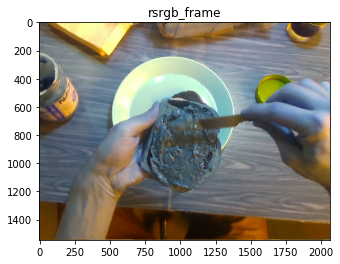

In [3]:
rsrgb_frame_adj = cv2.resize(rsrgb_frame, dsize=((np.shape(ximea_frame)[:2])[::-1]))
plt.imshow(rsrgb_frame_adj)
plt.title('rsrgb_frame')
plt.show()

## Adjust Ximea Image Brightness

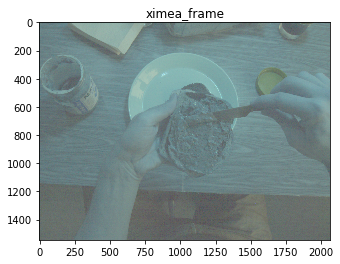

In [4]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

#adjust brightness of ximea so we can see something
#thresh = 75
#ximea_frame[ximea_frame>thresh]= thresh
#ximea_frame = ximea_frame/thresh

ximea_frame_adj = adjust_gamma(ximea_frame, gamma=5)

#make sure frames make sense
plt.imshow(ximea_frame_adj)
plt.title('ximea_frame')
plt.show()

Text(0.5, 1.0, 'Luminance Distributions')

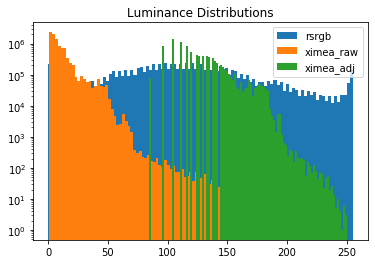

In [5]:
plt.hist(rsrgb_frame_adj.flatten(),bins=100,label='rsrgb');
plt.hist(ximea_frame.flatten(),bins=100,label='ximea_raw');
plt.hist(ximea_frame_adj.flatten(),bins=100,label='ximea_adj');
plt.yscale('log')
plt.legend()
plt.title('Luminance Distributions')

In [6]:
print(f'RSRGB shape: {np.shape(rsrgb_frame_adj)}')
print(f'Ximea shape: {np.shape(ximea_frame_adj)}')

RSRGB shape: (1544, 2064, 3)
Ximea shape: (1544, 2064, 3)


In [7]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(rsrgb_frame_adj,None)
kp2, des2 = sift.detectAndCompute(ximea_frame_adj,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5) #5 default
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [8]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2)
#G, mask = cv2.getAffineTransform(pts1,pts2)


# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]



(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f6415d410>,
 Text(0.5, 1.0, 'Ximea Frame'))

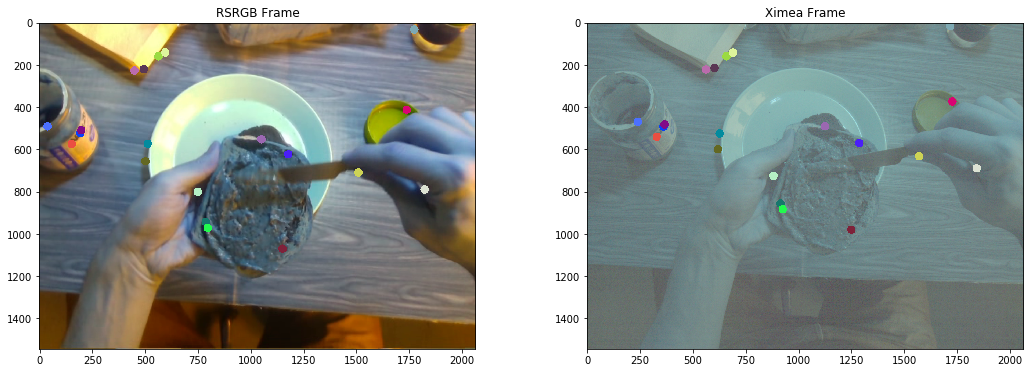

In [9]:
rsrgb_frame_points = rsrgb_frame_adj.copy()
ximea_frame_points = ximea_frame_adj.copy()

def drawpoints(img1,img2,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    '''
    r,c,_ = img1.shape
    for pt1,pt2 in zip(pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        img1 = cv2.circle(img1,tuple(pt1),20,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),20,color,-1)
    return img1,img2

img5,img6=drawpoints(rsrgb_frame_points, ximea_frame_points, pts1, pts2)
plt.close()
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(img5),plt.title('RSRGB Frame')
plt.subplot(122),plt.imshow(img6),plt.title('Ximea Frame')

## Apply Fundamental Matrix

this doesn't work and i don't know why....

[[-5.80306382e-07  1.81597113e-05 -1.46982763e-02]
 [-1.80163043e-05 -2.41800823e-06  3.11704029e-02]
 [ 1.46144741e-02 -2.85673764e-02  1.00000000e+00]]


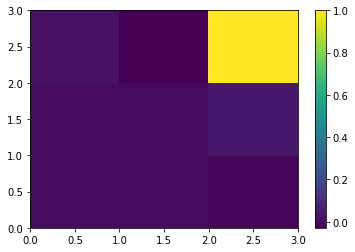

In [10]:
print(F)
plt.pcolormesh(F)
plt.colorbar()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1eec64fd10>,
 Text(0.5, 1.0, 'Ximea Frame'))

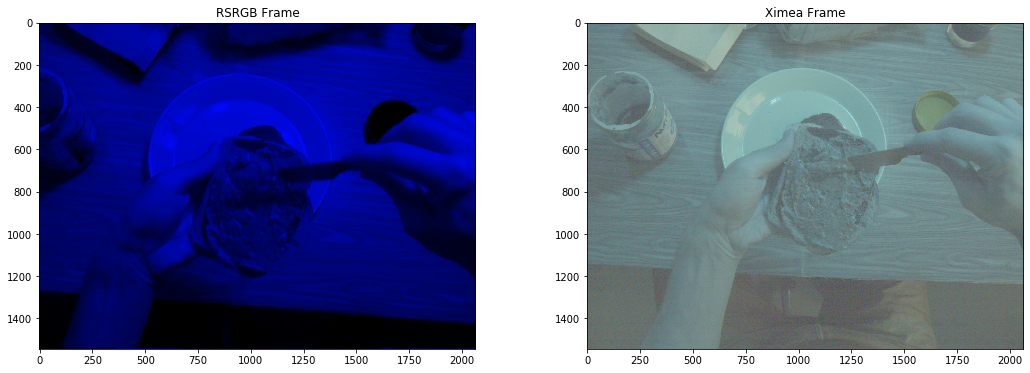

In [11]:
rsrgb_transformed = cv2.transform(rsrgb_frame_adj, F, np.shape(rsrgb_frame_adj))
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(rsrgb_transformed),plt.title('RSRGB Frame')
plt.subplot(122),plt.imshow(ximea_frame_adj),plt.title('Ximea Frame')

I really don't know whats going on here but it's not transforming the image so boo.

## Try Homography
hint.. this works!

[[ 8.57011575e-01  3.97756026e-02  1.64079298e+02]
 [-2.60205890e-02  8.52524706e-01  3.87681231e+01]
 [-1.14197028e-05 -3.74914713e-05  1.00000000e+00]]


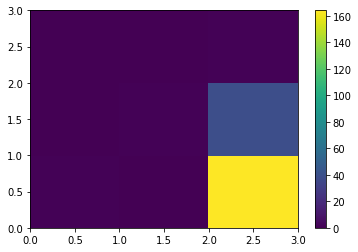

In [12]:
H = cv2.findHomography(pts1, pts2)

print(H[0])
plt.pcolormesh(H[0])
plt.colorbar()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1eec4f6910>,
 Text(0.5, 1.0, 'Ximea Frame'))

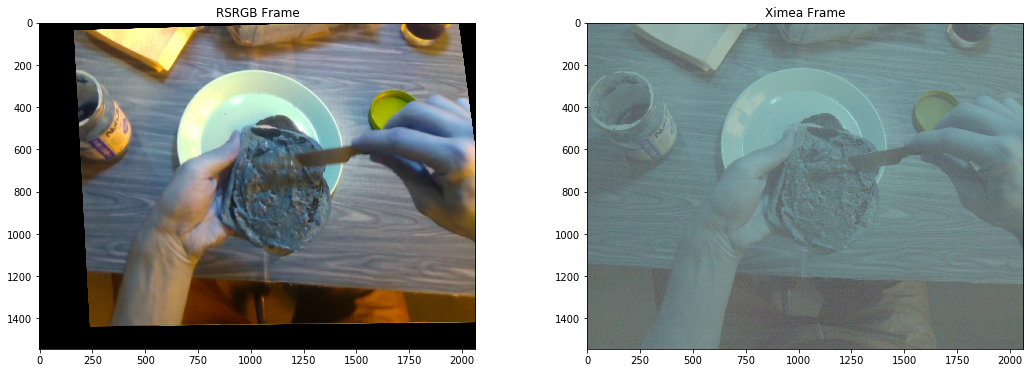

In [13]:
rsrgb_transformed = cv2.warpPerspective(rsrgb_frame_adj, H[0], np.shape(rsrgb_frame_adj)[:2][::-1])
plt.close()
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(rsrgb_transformed),plt.title('RSRGB Frame')
plt.subplot(122),plt.imshow(ximea_frame_adj),plt.title('Ximea Frame')


In [14]:
H[0].shape

(3, 3)

Text(0.5, 1.0, 'Ximea Frame: point at 604.2, 574.6')

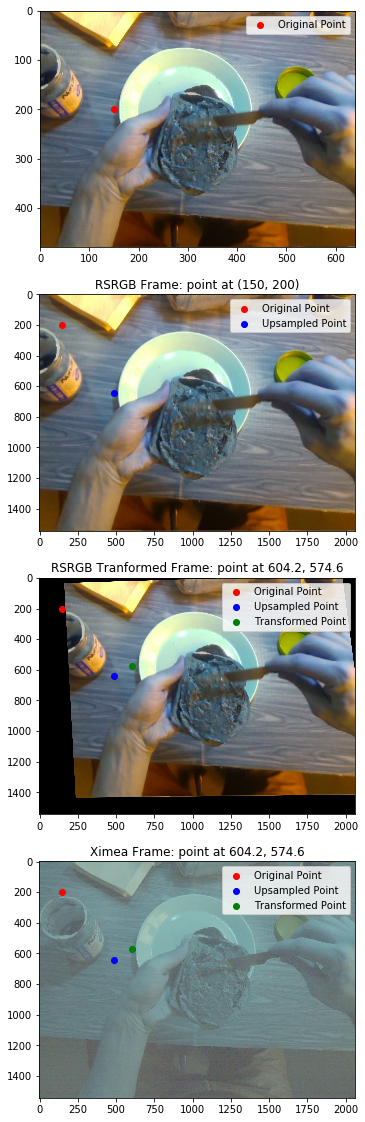

In [15]:
plt.close()
plt.figure(figsize=(8,20))
fix_x = 150
fix_y = 200

upsample_ratio_y = rsrgb_frame_adj.shape[0]/rsrgb_frame.shape[0]
upsample_ratio_x = rsrgb_frame_adj.shape[1]/rsrgb_frame.shape[1]

fix_x_up = fix_x * upsample_ratio_x
fix_y_up = fix_y * upsample_ratio_y

trans_fix_x, trans_fix_y, garbage = H[0]@(fix_x_up, fix_y_up, 1)

plt.subplot(411),plt.imshow(rsrgb_frame)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
#plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
#plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.subplot(412),plt.imshow(rsrgb_frame_adj)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
#plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'RSRGB Frame: point at {fix_x, fix_y}')
plt.subplot(413),plt.imshow(rsrgb_transformed)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'RSRGB Tranformed Frame: point at {trans_fix_x:.1f}, {trans_fix_y:.1f}')
plt.subplot(414),plt.imshow(ximea_frame_adj)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'Ximea Frame: point at {trans_fix_x:.1f}, {trans_fix_y:.1f}')
